<a href="https://colab.research.google.com/github/janbanot/msc-project/blob/main/test_notebooks/msc_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade transformers datasets captum quantus accelerate

In [2]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
import pandas as pd

csv_path = '/drive/MyDrive/msc-project/jigsaw-toxic-comment/train.csv'
try:
    df = pd.read_csv(csv_path)
    print("CSV file loaded successfully!")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file was not found at {csv_path}")
except Exception as e:
    print(f"An error occurred: {e}")

CSV file loaded successfully!


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
import re

def clean_text(example):
    """Applies all cleaning steps to the 'comment_text' field."""

    # 1. Get the text
    text = example['comment_text']

    # 2. Lowercasing
    # This is crucial for "uncased" BERT models
    text = text.lower()

    # 3. Remove URLs
    # re.sub finds a pattern and replaces it
    # r'http\S+' finds 'http' followed by any non-space characters
    text = re.sub(r'http\S+|www\S+', '', text)

    # 4. Remove IP Addresses
    # \d{1,3} means "a digit, 1-to-3 times". \. means "a literal dot".
    text = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', '', text)

    # 5. Remove Wikipedia metadata like (talk), timestamps, etc.
    # This is a simple regex to find things like (talk)
    # You could make this more complex, but this is a good start.
    text = re.sub(r'\(talk\)', '', text)
    text = re.sub(r'\d{2}:\d{2}, \w+ \d{1,2}, \d{4} \(utc\)', '', text)

    # 6. Remove newlines and other special characters
    text = text.replace('\n', ' ')
    text = text.replace('\xa0', ' ')

    # 7. Remove any text inside double quotes at the start/end
    # This removes things like '"\n\n ' from the beginning
    text = text.strip(' "')

    # 8. Clean up whitespace
    # \s+ means "one or more space characters"
    # We replace any group of spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()

    # 9. Update the example
    example['comment_text'] = text
    return example

In [5]:
import datasets

train_df = df.head(2000)
data = datasets.Dataset.from_pandas(train_df)

In [6]:
print("\nCleaning data...")
cleaned_data = data.map(clean_text)
print("Data cleaned!")


Cleaning data...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Data cleaned!


In [7]:
print("\n--- BEFORE CLEANING ---")
print(data[1]['comment_text'])
print("\n" + data[6]['comment_text'])
print("\n" + data[0]['comment_text'])

print("\n\n--- AFTER CLEANING ---")
print(cleaned_data[1]['comment_text'])
print("\n" + cleaned_data[6]['comment_text'])
print("\n" + cleaned_data[0]['comment_text'])


--- BEFORE CLEANING ---
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)

COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27


--- AFTER CLEANING ---
d'aww! he matches this background colour i'm seemingly stuck with. thanks.

cocksucker before you piss around on my work

explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.


In [8]:
from transformers import AutoTokenizer

# "model card"
# 'uncased' matches the .lower() step we did earlier.
model_checkpoint = "distilbert-base-uncased"

try:
    # This downloads and caches the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    print("Tokenizer loaded successfully!")
except Exception as e:
    print(f"Error loading tokenizer: {e}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer loaded successfully!


In [9]:
def tokenize_function(examples):
    """Applies the tokenizer to a batch of text."""

    # This is the main tokenization step.
    # padding="max_length" fills short comments with [PAD] tokens.
    # truncation=True cuts off comments that are too long.
    # max_length=256 is a good balance of speed and context for comments.
    # Could use 512 (DistilBERT's max) but it's slower.
    return tokenizer(
        examples["comment_text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

# Apply the function with .map()
# batched=True makes it MUCH faster by tokenizing many texts at once.
print("\nTokenizing data...")
tokenized_data = cleaned_data.map(tokenize_function, batched=True)
print("Data tokenized!")


Tokenizing data...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Data tokenized!


In [10]:
print("\n--- Example of a Tokenized Entry ---")
print(tokenized_data[0])


--- Example of a Tokenized Entry ---
{'id': '0000997932d777bf', 'comment_text': "explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.", 'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0, 'input_ids': [101, 7526, 2339, 1996, 10086, 2015, 2081, 2104, 2026, 5310, 18442, 13076, 12392, 2050, 5470, 2020, 16407, 1029, 2027, 4694, 1005, 1056, 3158, 9305, 22556, 1010, 2074, 8503, 2006, 2070, 3806, 2044, 1045, 5444, 2012, 2047, 2259, 14421, 6904, 2278, 1012, 1998, 3531, 2123, 1005, 1056, 6366, 1996, 23561, 2013, 1996, 2831, 3931, 2144, 1045, 1005, 1049, 3394, 2085, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [11]:
import numpy as np

# 1. Define label columns in the correct order
label_columns = [
    'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'
]

def create_labels_column(example):
    """
    Creates a new 'labels' column by combining the 6 label columns.
    We convert them to float32, which is what ML models expect.
    """
    # For each example, build a list of its label values
    labels_list = [float(example[col]) for col in label_columns]
    example['labels'] = labels_list
    return example

# 2. Apply the function
print("\nConsolidating labels...")
final_data = tokenized_data.map(create_labels_column)
print("Labels consolidated!")

# 3. Let's see the result for a toxic comment
print("\n--- Example of a Processed Entry ---")
print(final_data[6])


Consolidating labels...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Labels consolidated!

--- Example of a Processed Entry ---
{'id': '0002bcb3da6cb337', 'comment_text': 'cocksucker before you piss around on my work', 'toxic': 1, 'severe_toxic': 1, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0, 'input_ids': [101, 10338, 6342, 9102, 2077, 2017, 18138, 2105, 2006, 2026, 2147, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [12]:
# 1. List all columns we want to remove
columns_to_remove = [
    'id', 'comment_text', 'toxic', 'severe_toxic',
    'obscene', 'threat', 'insult', 'identity_hate'
]

print(f"\nOriginal columns: {final_data.column_names}")
final_data = final_data.remove_columns(columns_to_remove)
print(f"Cleaned columns: {final_data.column_names}")

# 2. Set the dataset format to "torch" (for PyTorch)
try:
    final_data.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    print("\nDataset format set to 'torch'!")
except ImportError:
    print("\nPyTorch not installed. Skipping .set_format('torch').")
    print("Please install with: pip install torch")

print("\n--- Final, Model-Ready Item ---")
print(final_data[6])


Original columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'input_ids', 'attention_mask', 'labels']
Cleaned columns: ['input_ids', 'attention_mask', 'labels']

Dataset format set to 'torch'!

--- Final, Model-Ready Item ---
{'input_ids': tensor([  101, 10338,  6342,  9102,  2077,  2017, 18138,  2105,  2006,  2026,
         2147,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
    

In [13]:
from transformers import AutoModelForSequenceClassification

num_labels = 6 # 6 toxic categories

# Load the model, configuring it for multi-label classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

print("Model loaded successfully!")
print("Model configured for multi-label classification.")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Model configured for multi-label classification.


In [14]:
data_splits = final_data.train_test_split(test_size=0.2, seed=42)

train_dataset = data_splits['train']
eval_dataset = data_splits['test']

print(f"\nData split complete:")
print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")


Data split complete:
Training samples: 1600
Evaluation samples: 400


In [16]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

def compute_metrics(p: EvalPrediction):
    # p.predictions are the raw logit outputs
    # p.label_ids are the true labels

    # Apply sigmoid to logits to get probabilities
    logits = p.predictions
    # Sigmoid function
    probs = 1 / (1 + np.exp(-logits))

    # Set a threshold (0.5) to get binary predictions
    threshold = 0.5
    predictions = (probs > threshold).astype(int)

    # Compute the metrics
    labels = p.label_ids

    # Use 'micro' averaging, which is good for imbalanced labels
    f1_micro = f1_score(labels, predictions, average='micro')

    # This measures how many individual labels (out of 6*num_samples) were correct
    overall_accuracy = accuracy_score(labels.flatten(), predictions.flatten())

    # Return metrics as a dictionary
    return {
        'f1_micro': f1_micro,
        'accuracy': overall_accuracy
    }

In [17]:
from transformers import TrainingArguments

model_output_dir = "/drive/MyDrive/msc-project/models/distilbert-jigsaw-finetuned"


training_args = TrainingArguments(
    output_dir=model_output_dir,
    learning_rate=2e-5,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    # helps prevent overfitting
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    # DISABLE WANDB
    report_to="none",
)

In [18]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("\n--- Starting Training ---")
trainer.train()
print("--- Training Complete ---")

/tmp/ipython-input-2197618380.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Starting Training ---


Epoch,Training Loss,Validation Loss,F1 Micro,Accuracy
1,0.136200,0.085198,0.544000,0.976250
2,0.058200,0.068439,0.693333,0.980833
3,0.036400,0.065271,0.687117,0.978750


--- Training Complete ---


In [19]:
save_directory = "/drive/MyDrive/msc-project/models/final_distilbert_jigsaw"
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved in: {save_directory}")

Model and tokenizer saved in: /drive/MyDrive/msc-project/models/final_distilbert_jigsaw


In [44]:
import torch
import torch.nn.functional as F

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

text = "you are a fucking moron, who should die in hell but I love your lovely kitten"

# Tokenization
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

# Inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    # Use SIGMOID dla multi-label
    probs = torch.sigmoid(logits)

# Display results
labels_list = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
print(f"Text: '{text}'\n")
print("Probabilities:")
for label, prob in zip(labels_list, probs[0]):
    print(f"{label}: {prob:.4f}")

Text: 'you are a fucking moron, who should die in hell but I love your lovely kitten'

Probabilities:
toxic: 0.8814
severe_toxic: 0.3082
obscene: 0.7687
threat: 0.2302
insult: 0.7914
identity_hate: 0.3179


In [46]:
from captum.attr import IntegratedGradients

# 1. Wrapper dla Captum
# Funkcja przyjmuje teraz WEKTORY (inputs_embeds), a nie ID tokenów
def predict_func(inputs_embeds, attention_mask=None):
    output = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask)
    return output.logits

# 2. Inicjalizacja prostego Integrated Gradients
ig = IntegratedGradients(predict_func)

# 3. Wybór etykiety do wyjaśnienia
# 0=toxic, 1=severe_toxic, 2=obscene, 3=threat, 4=insult, 5=identity_hate
TARGET_LABEL_INDEX = 0
target_name = labels_list[TARGET_LABEL_INDEX]

# --- NAPRAWA (THE FIX) ---
# Musimy ręcznie wyciągnąć embeddingi z modelu, aby Captum mogło na nich pracować

# A. Wektory dla naszego tekstu
input_ids = inputs.input_ids
# Wyciągamy wektory (floats) z warstwy embeddingów modelu
input_embeddings = model.distilbert.embeddings(input_ids)

# B. Wektory dla tła (Baseline - padding)
# Tworzymy tensor ID paddingu o tej samej długości co input
ref_input_ids = torch.tensor([tokenizer.pad_token_id] * input_ids.size(1), device=device).unsqueeze(0)
# Zamieniamy go na wektory
ref_input_embeddings = model.distilbert.embeddings(ref_input_ids)

# C. Maska uwagi (ważne, aby model wiedział, co jest paddingiem)
attention_mask = inputs.attention_mask

# 5. Obliczenie atrybucji
print(f"Obliczanie wyjaśnień dla etykiety: {target_name}...")

attributions, delta = ig.attribute(
    inputs=input_embeddings,         # Podajemy przygotowane wektory!
    baselines=ref_input_embeddings,  # Podajemy wektory tła!
    target=TARGET_LABEL_INDEX,
    additional_forward_args=(attention_mask,), # Przekazujemy maskę uwagi
    return_convergence_delta=True
)

print("Gotowe! Możesz przejść do wizualizacji (Krok 4).")

Obliczanie wyjaśnień dla etykiety: toxic...
Gotowe! Możesz przejść do wizualizacji (Krok 4).


In [47]:
# Przetwarzanie wyników do wizualizacji
attributions_sum = attributions.sum(dim=-1).squeeze(0)
attributions_sum = attributions_sum / torch.norm(attributions_sum)
attributions_np = attributions_sum.cpu().detach().numpy()

# Pobranie prawdopodobieństwa dla wybranej etykiety
prob_score = probs[0][TARGET_LABEL_INDEX].item()
pred_class_label = "True" if prob_score > 0.5 else "False"

# Pobranie tokenów
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Obiekt wizualizacji
vis_data = visualization.VisualizationDataRecord(
    word_attributions=attributions_np,
    pred_prob=prob_score,       # Prawdopodobieństwo tej konkretnej etykiety
    pred_class=pred_class_label, # Czy przekroczyło próg?
    true_class=1,               # Zakładamy, że wiemy, że tekst jest toksyczny
    attr_class=target_name,     # Nazwa etykiety (np. 'toxic')
    attr_score=attributions_np.sum(),
    raw_input_ids=tokens,
    convergence_score=delta
)

print(f"\nWyjaśnienie dla etykiety: {target_name}")
visualization.visualize_text([vis_data])


Wyjaśnienie dla etykiety: toxic


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,True (0.88),toxic,2.79,"[CLS] you are a fucking mor ##on , who should die in hell but i love your lovely kitten [SEP]"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,True (0.88),toxic,2.79,"[CLS] you are a fucking mor ##on , who should die in hell but i love your lovely kitten [SEP]"


In [49]:
import numpy as np
from tqdm import tqdm

# 1. Konfiguracja modelu
model.config.output_hidden_states = True

# 2. Funkcja do ekstrakcji (bez zmian)
def extract_hidden_states(data_subset, layer_index=4):
    model.eval()
    all_hidden_states = []
    all_labels = []

    print(f"Ekstrakcja danych z warstwy {layer_index}...")

    for i in tqdm(range(len(data_subset))):
        entry = data_subset[i]

        text = entry['input_ids'].unsqueeze(0).to(device)
        mask = entry['attention_mask'].unsqueeze(0).to(device)
        label = entry['labels'][0].item()

        with torch.no_grad():
            outputs = model(text, attention_mask=mask)
            hidden_state = outputs.hidden_states[layer_index]
            cls_embedding = hidden_state[0, 0, :].cpu().numpy()

            all_hidden_states.append(cls_embedding)
            all_labels.append(label)

    return np.array(all_hidden_states), np.array(all_labels)

# --- POPRAWKA TUTAJ ---
# Sprawdzamy ile mamy danych i bierzemy maksimum to co dostępne
total_eval_samples = len(eval_dataset)
target_size = 500
subset_size = min(target_size, total_eval_samples)

print(f"Dostępnych próbek: {total_eval_samples}. Używam: {subset_size}")

test_subset = eval_dataset.select(range(subset_size))

# Uruchomienie ekstrakcji
X_hidden, y_labels = extract_hidden_states(test_subset, layer_index=4)

print(f"\nKształt danych X: {X_hidden.shape}")
print(f"Kształt danych y: {y_labels.shape}")

Dostępnych próbek: 400. Używam: 400
Ekstrakcja danych z warstwy 4...


100%|██████████| 400/400 [00:03<00:00, 105.26it/s]


Kształt danych X: (400, 768)
Kształt danych y: (400,)


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# 1. Dzielimy nasze wyciągnięte "wnętrzności" na trening i test sondy
X_train_probe, X_test_probe, y_train_probe, y_test_probe = train_test_split(
    X_hidden, y_labels, test_size=0.2, random_state=42
)

# 2. Tworzymy i trenujemy prostą sondę (Regresja Logistyczna)
# Zwiększamy max_iter, żeby zdążyła się zbiec
probe = LogisticRegression(max_iter=1000)
probe.fit(X_train_probe, y_train_probe)

# 3. Sprawdzamy, jak dobrze sonda "widzi" toksyczność wewnątrz 4 warstwy
y_pred_probe = probe.predict(X_test_probe)

acc = accuracy_score(y_test_probe, y_pred_probe)
f1 = f1_score(y_test_probe, y_pred_probe)

print(f"--- Wyniki Sondy (Warstwa 4) ---")
print(f"Dokładność (Accuracy): {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Interpretacja
if acc > 0.80:
    print("Wniosek: Warstwa 4 ma BARDZO wyraźną reprezentację koncepcji 'toksyczność'!")
else:
    print("Wniosek: Informacja o toksyczności w tej warstwie jest rozmyta lub słaba.")

--- Wyniki Sondy (Warstwa 4) ---
Dokładność (Accuracy): 0.9625
F1 Score: 0.7692
Wniosek: Warstwa 4 ma BARDZO wyraźną reprezentację koncepcji 'toksyczność'!


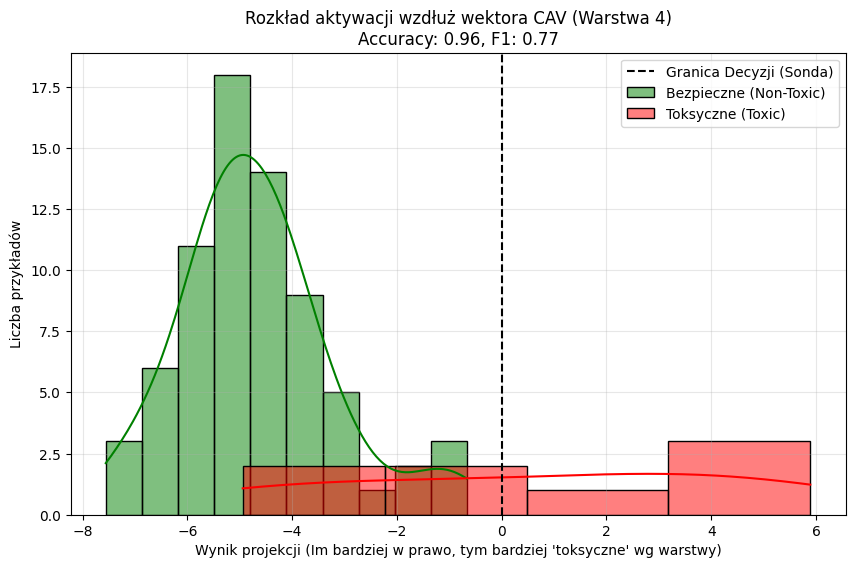

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Wyciągamy "Wektor Konceptu" (CAV) z wytrenowanej sondy
# To są wagi regresji logistycznej [1, 768]
cav_vector = probe.coef_[0]
intercept = probe.intercept_[0]

# 2. Rzutujemy dane na ten wektor (iloczyn skalarny)
# To nam powie, jak bardzo "wzdłuż" kierunku toksyczności leży każde zdanie
# Mnożymy macierz reprezentacji (X_test_probe) przez wektor CAV
projected_scores = np.dot(X_test_probe, cav_vector) + intercept

# 3. Przygotowanie danych do wykresu
# Dzielimy wyniki na grupę toksyczną (1) i bezpieczną (0) bazując na prawdziwych etykietach
scores_toxic = projected_scores[y_test_probe == 1]
scores_safe = projected_scores[y_test_probe == 0]

# 4. Rysowanie Histogramu
plt.figure(figsize=(10, 6))

# Rysujemy rozkład dla bezpiecznych (zielony)
sns.histplot(scores_safe, color="green", label="Bezpieczne (Non-Toxic)", kde=True, alpha=0.5)

# Rysujemy rozkład dla toksycznych (czerwony)
sns.histplot(scores_toxic, color="red", label="Toksyczne (Toxic)", kde=True, alpha=0.5)

plt.axvline(0, color='black', linestyle='--', label="Granica Decyzji (Sonda)")
plt.title(f"Rozkład aktywacji wzdłuż wektora CAV (Warstwa 4)\nAccuracy: {acc:.2f}, F1: {f1:.2f}")
plt.xlabel("Wynik projekcji (Im bardziej w prawo, tym bardziej 'toksyczne' wg warstwy)")
plt.ylabel("Liczba przykładów")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [52]:
import quantus
import numpy as np

# 1. Funkcja predykcji dla Quantus
# Quantus podaje dane jako numpy array, musimy je zamienić na Tensory
def model_predict_numpy(model, inputs, **kwargs):
    model.eval()
    # inputs to tutaj macierz ID tokenów [batch_size, seq_len]
    input_tensor = torch.tensor(inputs, device=device).long()

    with torch.no_grad():
        outputs = model(input_tensor)
        # Zwracamy prawdopodobieństwa (Softmax/Sigmoid) jako numpy
        return torch.sigmoid(outputs.logits).cpu().numpy()

# 2. Funkcja wyjaśniania dla Quantus (Integrated Gradients)
def explain_func_numpy(model, inputs, targets, **kwargs):
    # Wrapper, który uruchamia Twój kod IG wewnątrz Quantusa
    model.eval()
    input_tensor = torch.tensor(inputs, device=device).long()

    # Tworzymy wektory (tak jak naprawialiśmy to wcześniej)
    input_embeddings = model.distilbert.embeddings(input_tensor)

    # Baseline (padding)
    ref_input_ids = torch.tensor([tokenizer.pad_token_id] * inputs.shape[1], device=device).unsqueeze(0)
    ref_input_embeddings = model.distilbert.embeddings(ref_input_ids)

    # IG
    ig = IntegratedGradients(lambda x: model(inputs_embeds=x).logits)

    # Ważne: pętla po batchu (Quantus czasem podaje kilka przykładów na raz)
    attributions_list = []
    for i in range(len(inputs)):
        # Cel (która klasa?)
        target_idx = int(targets[i])

        attr = ig.attribute(
            inputs=input_embeddings[i].unsqueeze(0),
            baselines=ref_input_embeddings,
            target=target_idx,
            n_steps=20 # Mniej kroków dla szybkości testu
        )
        # Sumujemy atrybucje do jednego wymiaru (per token)
        attr_sum = attr.sum(dim=-1).squeeze(0).cpu().detach().numpy()
        attributions_list.append(attr_sum)

    return np.array(attributions_list)

print("Wrappery dla Quantus gotowe.")

Wrappery dla Quantus gotowe.


In [60]:
import torch
import numpy as np

# --- KONFIGURACJA ---
TOP_K_TOKENS = 5   # Ile najważniejszych słów usuwamy?
dataset_samples = x_batch_toxic # Bierzemy nasze 16 toksycznych zdań
targets = y_batch_targets       # Nasze etykiety

print(f"--- Ręczna Ewaluacja Faithfulness (Comprehensiveness) ---")
print(f"Test na {len(dataset_samples)} przykładach.")
print(f"Usuwamy {TOP_K_TOKENS} najważniejszych słów z każdego zdania.\n")

scores = []

# Pętla po każdym przykładzie z osobna
for i in range(len(dataset_samples)):
    # 1. Przygotowanie pojedynczego wejścia
    input_id = torch.tensor([dataset_samples[i]], device=device) # Shape [1, seq_len]

    # 2. Oryginalna predykcja
    model.eval()
    with torch.no_grad():
        orig_output = model(input_id)
        orig_prob = torch.sigmoid(orig_output.logits)[0][0].item() # Prawdopodobieństwo klasy 'Toxic'

    # 3. Obliczenie atrybucji (IG) dla tego przykładu
    # (Używamy Twojego istniejącego obiektu ig, zakładam że 'ig' jest zdefiniowane z poprzednich kroków)
    # Jeśli nie, odkomentuj linię poniżej:
    ig = IntegratedGradients(predict_func)

    # Musimy przygotować embeddingi
    input_emb = model.distilbert.embeddings(input_id)
    baseline_emb = model.distilbert.embeddings(torch.tensor([tokenizer.pad_token_id] * input_id.size(1), device=device).unsqueeze(0))

    # Liczymy atrybucje
    attributions, _ = ig.attribute(
        inputs=input_emb,
        baselines=baseline_emb,
        target=0, # Celujemy w klasę Toxic
        return_convergence_delta=True
    )

    # Sumujemy atrybucje do poziomu tokenów
    attr_sum = attributions.sum(dim=-1).squeeze(0) # [seq_len]

    # 4. Znalezienie TOP-K najważniejszych tokenów
    # torch.topk zwraca wartości i indeksy
    _, top_indices = torch.topk(attr_sum, k=TOP_K_TOKENS)

    # 5. PERTURBACJA (Usunięcie słów)
    # Kopiujemy input i zastępujemy ważne słowa paddingiem (lub maską)
    perturbed_input_id = input_id.clone()
    # Wstawiamy PAD (id: 0) w miejsca najważniejszych słów
    perturbed_input_id[0, top_indices] = tokenizer.pad_token_id

    # 6. Nowa predykcja na "ocenzurowanym" tekście
    with torch.no_grad():
        pert_output = model(perturbed_input_id)
        pert_prob = torch.sigmoid(pert_output.logits)[0][0].item()

    # 7. Obliczenie wyniku (Comprehensiveness)
    # O ile spadła pewność modelu?
    drop = orig_prob - pert_prob
    scores.append(drop)

    # Opcjonalnie: wypisz podgląd dla pierwszego elementu
    if i == 0:
        print(f"Przykład 1 - Oryginalna pewność: {orig_prob:.4f}")
        print(f"Przykład 1 - Po usunięciu top-{TOP_K_TOKENS} słów: {pert_prob:.4f}")
        print(f"Przykład 1 - Spadek (Score): {drop:.4f}")
        removed_words = tokenizer.convert_ids_to_tokens(input_id[0, top_indices])
        print(f"Usunięte słowa: {removed_words}\n")

# --- WYNIKI KOŃCOWE ---
avg_score = np.mean(scores)
std_score = np.std(scores)

print("-" * 30)
print(f"Średni wynik Comprehensiveness: {avg_score:.4f}")
print(f"Odchylenie standardowe: {std_score:.4f}")

if avg_score > 0.1:
    print("\n✅ WNIOSEK: Metoda IG działa! Usunięcie wskazanych słów znacząco obniża toksyczność.")
else:
    print("\n❌ WNIOSEK: Metoda IG słabo wskazuje ważne słowa (model nadal myśli, że to toksyk).")

/tmp/ipython-input-4244441499.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  input_id = torch.tensor([dataset_samples[i]], device=device) # Shape [1, seq_len]
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


--- Ręczna Ewaluacja Faithfulness (Comprehensiveness) ---
Test na 16 przykładach.
Usuwamy 5 najważniejszych słów z każdego zdania.

Przykład 1 - Oryginalna pewność: 0.0634
Przykład 1 - Po usunięciu top-5 słów: 0.0591
Przykład 1 - Spadek (Score): 0.0042
Usunięte słowa: ['[SEP]', 'you', 'go', 'loser', 'to']

------------------------------
Średni wynik Comprehensiveness: 0.2572
Odchylenie standardowe: 0.2883

✅ WNIOSEK: Metoda IG działa! Usunięcie wskazanych słów znacząco obniża toksyczność.
